Este tutorial visa ir passo a passo explorar a presença de viés histórico e injustiça em um conjunto de dados.

Instalando as dependências

In [1]:
!pip install surprise

import pandas as pd
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=baec1cfd74bdb6e56210a168d36180894999f7e8b456530292a9b93a11b660df
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Importando o dataset

In [2]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat  -O ./ratings.dat
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat  -O ./movies.dat

--2024-11-24 15:12:17--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4318513 (4.1M) [text/plain]
Saving to: ‘./ratings.dat’

./ratings.dat       100%[===================>]   4.12M  --.-KB/s    in 0.1s    

2024-11-24 15:12:18 (39.8 MB/s) - ‘./ratings.dat’ saved [4318513/4318513]

--2024-11-24 15:12:18--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

Carregar o dataset na memória

In [3]:
df = pd.read_csv("./ratings.dat", sep=",")
print(df.head())

n_filmes = len(df['item'].unique())
n_usuarios = len(df['user'].unique())

print("Numero de Usuarios: ", n_usuarios)
print("Numero de filmes: ", n_filmes)

   user  item  rating  timestamp
0  1648  3114       5  974713543
1   305   742       2  976497760
2  3091  1347       3  969659451
3  4335  3098       4  965338778
4  4116  2389       3  966916499
Numero de Usuarios:  6037
Numero de filmes:  3465


In [4]:
from charset_normalizer import detect

# Detectar a codificação
with open("./movies.dat", "rb") as f:
    result = detect(f.read())
    print(result)  # Mostra a provável codificação

# Use a codificação detectada
df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], engine='python', encoding=result['encoding'])
df_genres.head()


{'encoding': 'windows-1250', 'language': 'English', 'confidence': 1.0}


,item,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Para facilitar futuramente, faz-se um dicionário relacionando filmes e seuss gêneros

In [ ]:
genre_map = {i['item']:i['genres'].split("|") for i in df_genres[['item', 'genres']].to_dict('records')}

Aqui, faz-se a divisão do conjunto de dados entre treino e teste

In [6]:
train, test = train_test_split(df, test_size=.3, random_state=42)

Aqui, faz-se uma função que obtém a distribuição de gêneros que o usuário de determinado id assiste.

In [7]:
def get_user_profile_distribution(df, user):
    user_profile_distribution = {}
    n = 0
    for item in df[df['user'] == user]['item'].values:

        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1

    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    return user_profile_distribution

Aqui é uma função que exibe um gráfico da distribuição acima.

In [8]:
def plot_user_profile_distribuition(user_id):
  user_profile_distribution = get_user_profile_distribution(train, user_id)

  plt.figure(figsize=(12, 8))
  sns.barplot(
      x=[i[0] for i in user_profile_distribution.items()],
      y=[i[1]*100 for i in user_profile_distribution.items()], color='gray'
  )
  plt.xticks(rotation=45)
  plt.xlabel("Generos")
  plt.ylabel("Presença do Genero no Perfil (%)")
  plt.grid()
  plt.show()

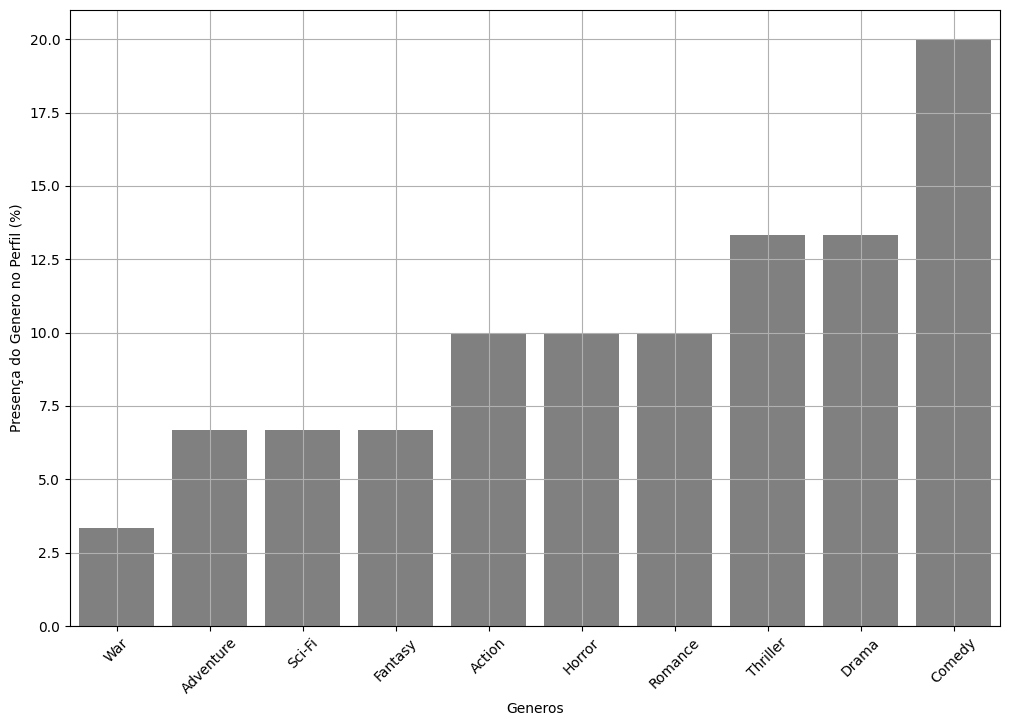

In [9]:
plot_user_profile_distribuition(552)

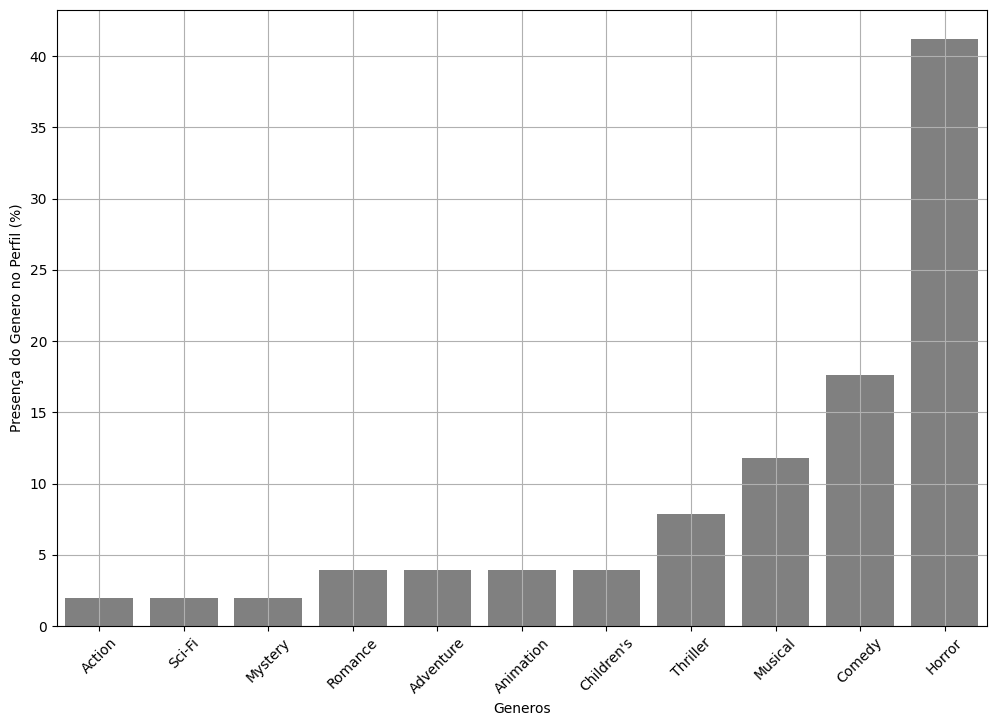

In [10]:
plot_user_profile_distribuition(305)

Neste bloco, faz-se o treinamento do modelo KNNBasic "User Based", a fim de gerar uma recomendação com os top-10 itens para os usuários.

In [16]:
from  surprise.prediction_algorithms.slope_one import SlopeOne

reader = Reader(rating_scale = (0, 5))

trainset = Dataset.load_from_df(
    train[["user", "item", "rating"]], reader=reader
).build_full_trainset()

userknn = KNNBasic(K=10, sim_options={"user_based": True, "similarities": 'cosine'})
userknn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [17]:
new_predictions = []
prediction_user_map = {}
data_p2 = []

for user in tqdm.tqdm(sorted(test['user'].unique())[:500]):
    data = {"item": list(set(df["item"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["rating"] = 0.0
    user_testset_df["user"] = user

    testset = (
        Dataset.load_from_df(
            user_testset_df[["user", "item", "rating"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in userknn.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    new_predictions.append(predictions[:10])
    prediction_user_map[user] = predictions[:10]



100%|██████████| 500/500 [01:59<00:00,  4.18it/s]


Aqui, faz-se a definição de uma função que vê a distribuição de gêneros dos filmes recomendados.

In [18]:
def get_user_recommendation_distribution(prediction_user_map):
    user_rec_distribution = {}
    n = 0
    for (item, score) in prediction_user_map:
        for genre in genre_map[item]:
            if genre not in user_rec_distribution:
                user_rec_distribution[genre] = 0
            n += 1
            user_rec_distribution[genre] += 1

    user_rec_distribution = {k: v/n for k, v in sorted(user_rec_distribution.items(), key=lambda item: item[1])}
    return user_rec_distribution

Aqui, tem-se uma função que compara ambas as distribuições. A ideia é ver se a predição respeita propriamente as preferências do usuário e não ocorreu nenhuma injustiça ou viés

In [19]:
def compare_distribuitions(user_id):
  user_rec_distribution = get_user_recommendation_distribution(prediction_user_map[user_id])
  user_profile_distribution = get_user_profile_distribution(train, user_id)



  plt.figure(figsize=(12, 8))

  x_map = {}
  n = 0
  for genre in user_profile_distribution:
      if genre not in x_map:
          x_map[genre] = n
          n += 2
  for genre in user_rec_distribution:
      if genre not in x_map:
          x_map[genre] = n
          n += 2

  plt.bar(
      x=[x_map[i[0]] for i in user_profile_distribution.items()],
      height=[i[1] for i in user_profile_distribution.items()],
      color='blue', label="Perfil", width=0.8, alpha=0.6
  )

  plt.bar(
      x=[x_map[i[0]]+0.8 for i in user_rec_distribution.items()],
      height=[i[1] for i in user_rec_distribution.items()],
      color='gray', label="Recomendações",width=0.8
  )

  plt.xticks(rotation=45)
  plt.xlabel("Generos")
  plt.ylabel("Presença do Genero (%)")
  plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
  plt.grid()
  plt.legend()
  plt.show()

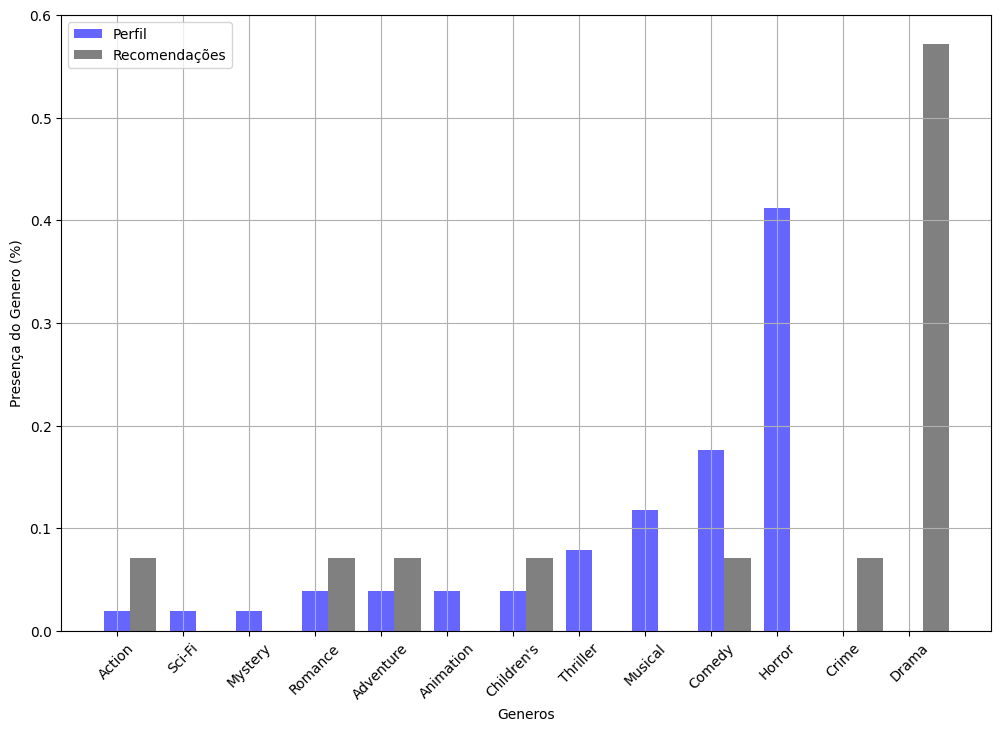

In [20]:
compare_distribuitions(305)

Pode-se ver, portanto, que o modelo ignora completamente o gosto do usuário e processa os filmes injustamente.